In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime(2023,6,1)

data = yf.download(crypto_currency, start, end)
Bdata = yf.download("BTC-USD", start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [2]:
price_scaler = MinMaxScaler(feature_range=(0,1))
Bprice_scaler = MinMaxScaler(feature_range=(0,1))

scaled_price = price_scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_Bprice = Bprice_scaler.fit_transform(Bdata['Close'].values.reshape(-1,1))


prediction_days = 60

x_train, y_train = [], []

for i in range(prediction_days, len(scaled_price)):
    x_train.append(np.column_stack((scaled_price[i-prediction_days:i, 0], scaled_Bprice[i-prediction_days:i, 0])))
    y_train.append(scaled_price[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

Epoch 1/25
62/62 [==============================] - 3s 28ms/step - loss: 0.0120
Epoch 2/25
62/62 [==============================] - 2s 29ms/step - loss: 0.0029
Epoch 3/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0034
Epoch 4/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0030
Epoch 5/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0028
Epoch 6/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0025
Epoch 7/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0027
Epoch 8/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0024
Epoch 9/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0021
Epoch 10/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0023
Epoch 11/25
62/62 [==============================] - 2s 31ms/step - loss: 0.0021
Epoch 12/25
62/62 [==============================] - 2s 30ms/step - loss: 0.0019
Epoch 13/25
62/62 [==================

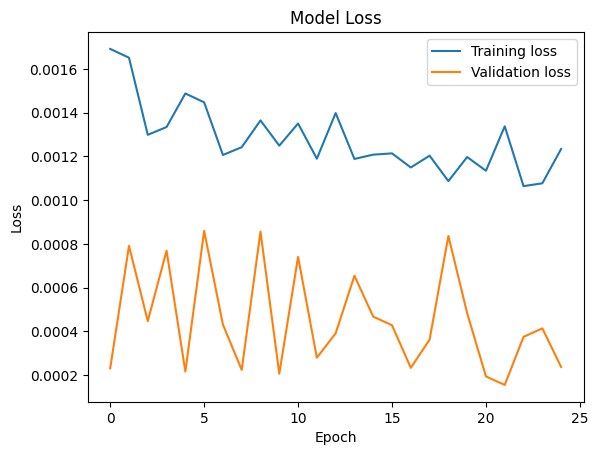

In [3]:

import keras
from keras import layers
model = keras.Sequential()
model.add(layers.LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(optimizer= 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)



history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)


plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 7ms/step


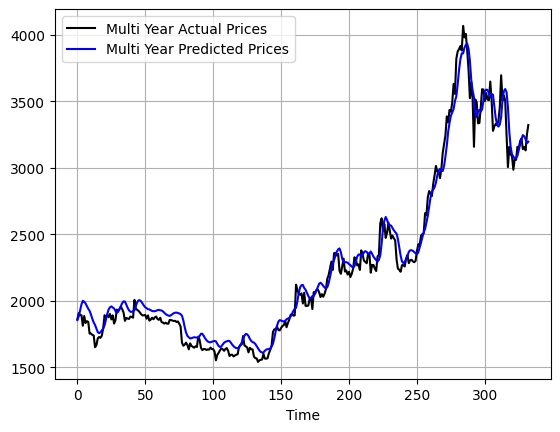

avg distance from actual price [74.748955]
Correct, Wrong and ratio if predicting price is up every day 171 161 0.5150602409638554
overall correct: 171 overall wrong: 161
longest overall correct streak: 7 longest overall wrong streak: 6
explained variance score: 0.98157556106287
prediction window: 60


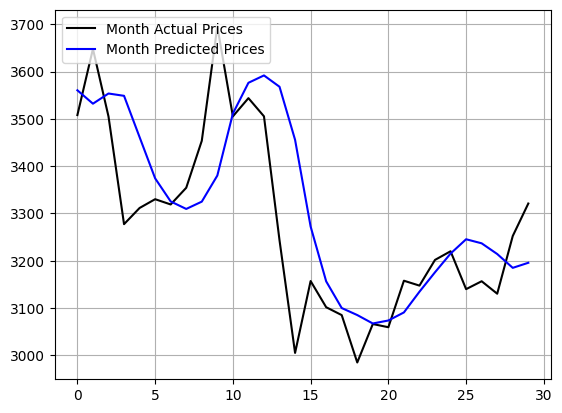

correct: 17 wrong: 12
longest correct streak: 4 longest wrong streak: 3


In [4]:

test_start = dt.datetime(2023,6,1)
test_end = dt.datetime.now()

test_data = yf.download(crypto_currency, test_start, test_end)
Btest_data = yf.download(crypto_currency, test_start, test_end)

actual_prices = test_data['Close'].values


total_dataset = pd.concat((data['Close'], Btest_data['Close']), axis=0)
total_Bdataset = pd.concat((Bdata['Close'], Btest_data['Close']), axis=0)


model_inputs_price = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_Bprice = total_Bprice_dataset[len(total_Bprice_dataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)

model_inputs_price = price_scaler.transform(model_inputs_price)  
model_inputs_Bprice = Bprice_scaler.transform(model_inputs_Bprice)

#model_inputs_price = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
#model_inputs_volume = pd.concat((data['Volume'], test_data['Volume']), axis=0).values.reshape(-1,1)
#model_inputs_price = price_scaler.transform(model_inputs_price)  
#model_inputs_volume = volume_scaler.transform(model_inputs_volume) 

x_test = []


for i in range(prediction_days, len(model_inputs_price)):
    x_test.append(np.column_stack((model_inputs_price[i-prediction_days:i, 0], model_inputs_Bprice[i-prediction_days:i, 0])))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))


prediction_prices = model.predict(x_test)
prediction_prices = price_scaler.inverse_transform(prediction_prices[:, 0].reshape(-1, 1))


prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)

plt.show()
correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
for i in range(len(prediction_prices)):
    avg += abs(prediction_prices[i] - actual_prices[i])
    if i != 0:
        if actual_prices[i] > actual_prices[i- 1]:
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)

plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)